In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

In [11]:
graph=nx.read_edgelist('graph.txt',nodetype=int)

In [12]:
print(type(graph))

<class 'networkx.classes.graph.Graph'>


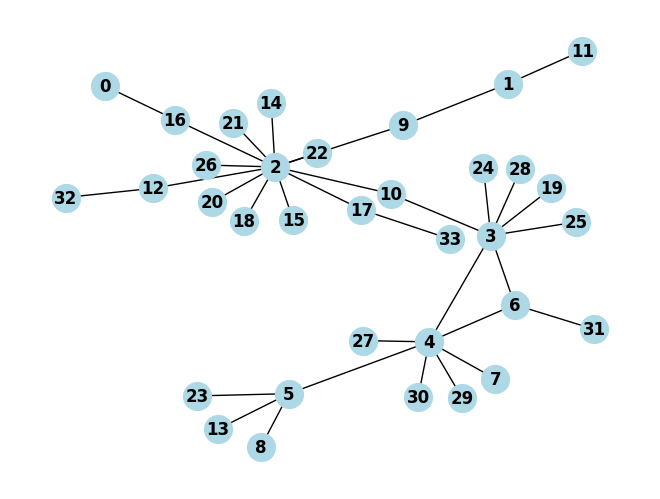

In [13]:
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=400, font_size=12, font_color='black', font_weight='bold')
plt.show()

In [14]:
def findNeighborEdges(graph,edge):
    neighborEdges = [(edge[0],neighbor) for neighbor in graph.neighbors(edge[0])] + [(edge[1],neighbor) for neighbor in graph.neighbors(edge[1])]
    return [i for i in neighborEdges if (i!=edge and i!=edge[::-1])]

# def initializePopulation(graph):

In [15]:
class Individual:
    def __init__(self, sets):
        self.size = sum(len(s) for s in sets)
        self.loci = [(None, None) for _ in range(self.size)]
        self.gene = [(None, None) for _ in range(self.size)]
        self._populate_individual(sets)

    def _populate_individual(self, sets):
        current_position = 0
        for set in sets:
            visited = {t: 0 for t in set}
            random_set = list(set)
            random.shuffle(random_set)
            for cur_tuple in set:
                value_assigned = False
                
                for other_tuple in random_set:
                    if visited[other_tuple] or other_tuple == cur_tuple:
                        continue
                    if self.adjacent(cur_tuple, other_tuple):
                        self.loci[current_position] = cur_tuple
                        self.gene[current_position] = other_tuple
                        current_position += 1
                        value_assigned = True
                        visited[other_tuple] = 1
                        break

                if not value_assigned:
                    for t in random_set:
                        if(not visited[t]): other_tuple=t 
                    self.loci[current_position] = cur_tuple
                    self.gene[current_position] = other_tuple
                    visited[cur_tuple] = 1
                    current_position += 1

    def adjacent(self, t1, t2):
        if t1[0] == t2[0] or t1[0] == t2[1] or t1[1] == t2[0] or t1[1] == t2[1]:
            return True
        return False

    def decode(self):
        labels = {l: 0 for l in self.loci}

        c=1
        for i in range(self.size):
            if labels[self.loci[i]] == 0 and labels[self.gene[i]] == 0:
                labels[self.loci[i]]=c
                labels[self.gene[i]]=c
                c+=1
            elif labels[self.loci[i]] == 0:
                labels[self.loci[i]] = labels[self.gene[i]]
            elif labels[self.gene[i]] == 0:
                labels[self.gene[i]] = labels[self.loci[i]]

        value_to_keys = {}
        for key, value in labels.items():
            if value in value_to_keys:
                value_to_keys[value].add(key)
            else:
                value_to_keys[value] = {key}
        return list(value_to_keys.values())

    def get_gene(self,index):
        return self.loci[index],self.gene[index]
    
    def set_gene(self,index,loci_value,gene_value):
        self.gene[index]=gene_value
        self.loci[index]=loci_value

    def __eq__(self,other):
        for i in range(len(self.gene)):
            if (self.gene[i]!=other.gene[i] or self.loci[i]!=other.loci[i]) : return False
        return True

    def __str__(self):
        loci_str = ', '.join(map(str, self.loci))
        gene_str = ', '.join(map(str, self.gene))
        return f"Loci: [{loci_str}]\nGene: [{gene_str}]"

In [16]:
def most_frequent_label(labels, graph, v):
    neighbors_of_v = list(graph.neighbors(v))
    max_value = max(labels[key] for key in neighbors_of_v)
    max_keys = [key for key in neighbors_of_v if labels[key] == max_value]
    return random.choice(max_keys)

def node_to_edge_community(labels,graph):
    communities={}
    for edge in graph.edges():
        u, v = edge
        if labels[u] == labels[v]:
            community=labels[u]
        else : 
            community = random.choice([labels[u],labels[v]])
        if community in communities:
            communities[community].add(edge)
        else : communities[community] ={edge}
    return [value_set for value_set in communities.values()]

def label_propagation(graph):
    stop = False
    labels = {node: node for node in graph.nodes()}
    while not stop:
        stop = True
        shuffled_nodes = list(graph.nodes())
        random.shuffle(shuffled_nodes)
        for v in shuffled_nodes:
            current = labels[v]
            labels[v] = most_frequent_label(labels, graph, v)

            if labels[v] != current:
                stop = False

    communities=node_to_edge_community(labels,graph)
    individual = Individual(communities)
    return individual
    
    

label_propagation(graph)

In [35]:
#local expansion
def natural_community(graph, seed):
    nodes = list(graph.neighbors(seed)) + [seed]
    res = graph.subgraph(nodes)
    return res

def local_expansion(graph,given_nodes):
    communities = {}
    visited = {node: 0 for node in given_nodes}
    labels = {node: node for node in graph.nodes()}
    for seed in given_nodes:
        if visited[seed]:
            continue
        visited[seed] = 1
        nat_com = natural_community(graph, seed)
        for node in list(nat_com.nodes()):
            labels[node] = seed
    communities = node_to_edge_community(labels, graph)
    for i in communities:print(i)
    individual = Individual(communities)
    return individual

def local_expansion_random(graph):
    shuffled_nodes = list(graph.nodes())
    random.shuffle(shuffled_nodes)
    return local_expansion(graph,shuffled_nodes)

def local_expansion_by_degree(graph):
    degrees=dict(graph.degree())
    sorted_nodes = sorted(degrees, key = lambda x : degrees[x], reverse = True)
    return local_expansion(graph,sorted_nodes)

def local_expansion_by_eigenvector_centrality(graph):
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    sorted_nodes = [node for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)]
    return local_expansion(graph,sorted_nodes)


# local_expansion_by_degree(graph)
edges=graph.edges()
edges=sorted(edges)
print(edges)

[(0, 16), (1, 9), (1, 11), (2, 10), (2, 12), (2, 14), (2, 15), (2, 17), (2, 18), (2, 20), (2, 21), (2, 22), (2, 26), (3, 4), (3, 6), (3, 19), (3, 24), (3, 25), (3, 28), (4, 5), (4, 7), (4, 27), (4, 29), (4, 30), (5, 8), (5, 13), (5, 23), (6, 4), (6, 31), (9, 2), (10, 3), (12, 32), (16, 2), (17, 33)]


In [ ]:
local_expansion

In [19]:
#Link Partition Density
def fitness(individual):
    communities = individual.decode();
    ans=0
    total_edge=0
    for community in communities:
        nodes=set()
        for edge in community:
            nodes.add(edge[0])
            nodes.add(edge[1])
        n = len(nodes)
        m = len(community)
        total_edge+=m
        if(n < 3):
            continue
        ans += (m*((m-(n-1))/((n-1)*(n-2))))
    ans *= (len(communities)/total_edge)
    return ans

def evaluate_population(tree):
    ans=[]
    for subtree in tree:
        for individual in subtree:
            ans.append(fitness(individual))
    return ans

In [ ]:
from math import inf
def update_population(tree):
    for subtree in tree:
        max=-inf
        maxi=-1
        for i in range(len(subtree)):
            fitness_value = fitness(subtree[i])
            if fitness_value>max:
                max=fitness_value
                maxi=i
        subtree[0],subtree[maxi]=subtree[maxi],subtree[i]
    
    for i in range(13,0,-1):
        leader = ((i+1)//3)
        supp_fitness = fitness(tree[i][0])
        lead_fitness = fitness(tree[leader][0])
        if supp_fitness > lead_fitness :
            tree[i][0],tree[leader][0] = tree[leader][0],tree[i][0]
    return tree


In [21]:
def initialize_population(graph):
    tree=[]
    for i in range(13):
        subtree=[]
        for j in range(7):
            initializers=[local_expansion_random,local_expansion_by_degree,
                            local_expansion_by_eigenvector_centrality,label_propagation]
            chosen_function = random.choice(initializers)
            subtree.append(chosen_function(graph))
        tree.append(subtree)
    tree=update_population(tree)
    return tree


In [26]:
def lost_diversity(initial, later):
    if np.std(initial)/np.std(later) < .5:
        return True
    return False


def get_best(tree):
    best = []
    mx = -inf
    for subtree in tree:
        for individual in subtree:
            score = fitness(individual)
            if score > mx:
                best = individual
                mx = score
    return best






In [32]:
def select(agent):
    return random.choice(agent)
def close_select(tree,index):
    target_index=random.choice[index*3+1,index*3+2,index*3+3]
    return random.choice(tree[target_index])

def far_select(tree,index):
    avoid=[index*3+1,index*3+2,index*3+3,index]
    target=[i for i in range(13) if (i!=0 and i not in avoid)]
    target_index=random.choice(target)
    return random.choice(tree[target_index])

def choose_parents(tree,index,eval):
    if index==0:
        parent1=random.choice(tree[0])
        parent2=random.choice(random.choice(tree[1:]))
    elif index>3:
        parent1=random.choice(tree[index])
        leader=(index-1)//3
        avoid= [leader*3+1,leader*3+2,leader*3+3]
        target = [i for i in range(4,13) if i not in avoid]
        x=random.choice(target)
        parent2=random.choice(tree[x])
    else:
        parent1=random.choice(tree[index])
        if lost_diversity(eval, evaluate_population(tree)):
            parent2 = close_select(tree,index)
        else:
            parent2 = far_select(tree,index)
    return parent1,parent2
# choose_parents(4,10)


[4, 5, 6, 7, 8, 9]

In [ ]:
def crossover(parent1, parent2, cp):
    for i in range(len(parent1)):
        if random.uniform(0,1) < cp :
            loci,gene=parent1.get_gene(i)
            parent2.set_gene(i,loci,gene)
    return parent2

def mutate(offspring):
    


In [27]:
def m_link(adj, lsp=0.1, cp=0.5, mp=0.05, generation_without_improvemnt=35):
    treePopulation = initialize_population(graph)
    eval = evaluate_population(treePopulation)
    prev_best = get_best(treePopulation)
    best = get_best(treePopulation)

    terminate = False
    generation_with_same_best = 0

    while not terminate:

        for index, agent in enumerate(treePopulation):

            parent1, parent2=choose_parents(treePopulation, index, eval)

            offspring = crossover(parent1, parent2, cp)
            mutate(offspring)

            if (random.uniform(0, 1) < lsp):
                localSearch(offspring)

            updatePopulation(offspring)

        best = get_best(treePopulation)
        if best == prev_best:
            generation_with_same_best += 1
        else:
            generation_with_same_best = 0
        if generation_with_same_best >= generation_without_improvemnt:
            terminate = True
    overlappingCommunities = postProcessing(getBest(treePopulation))